In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install albumentations

# Dataset Augmentation



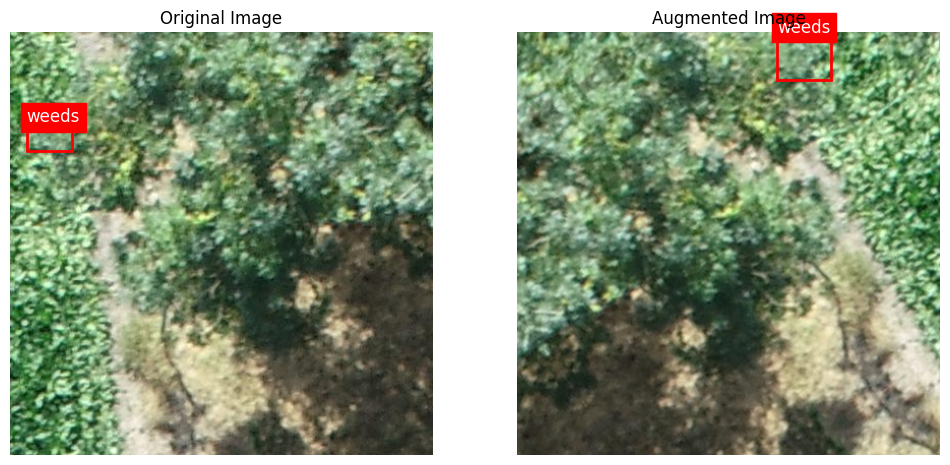

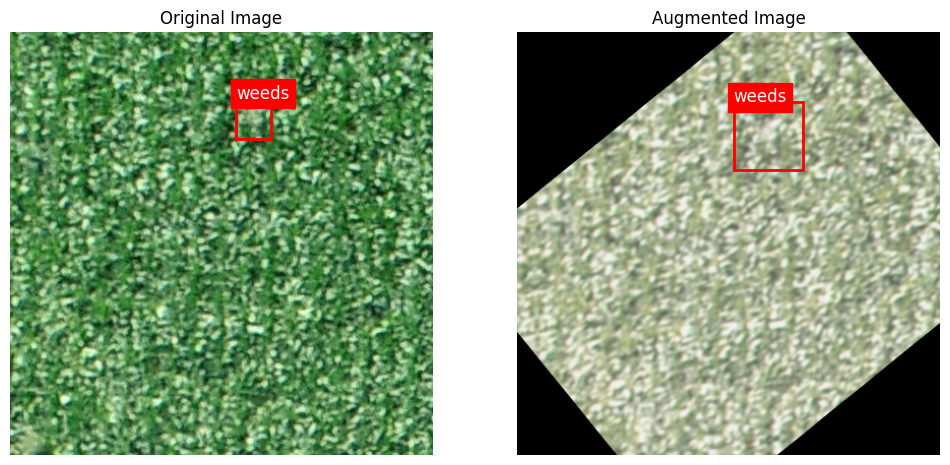

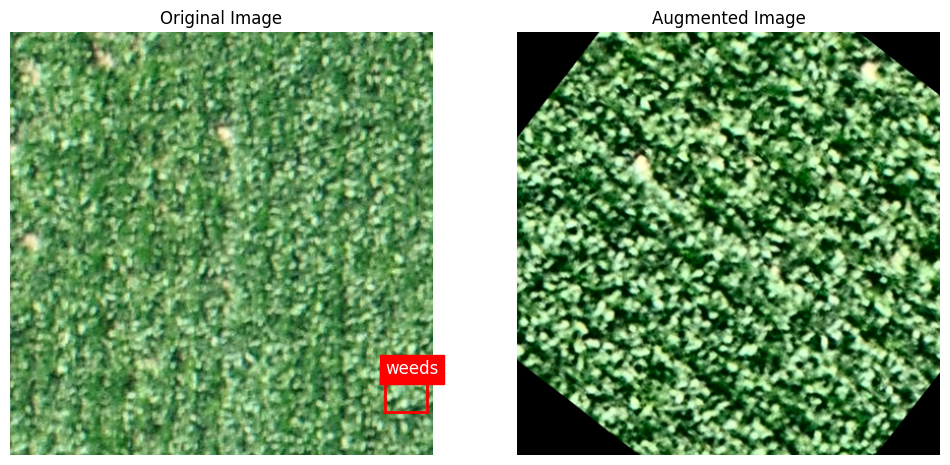

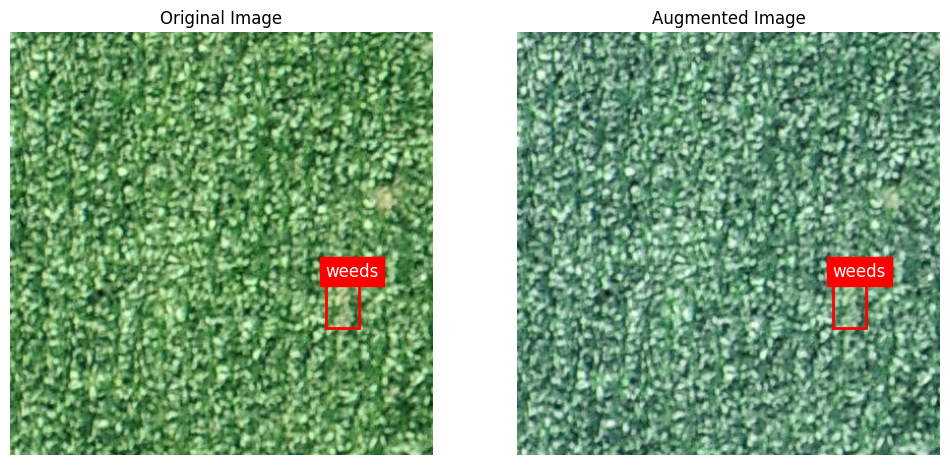

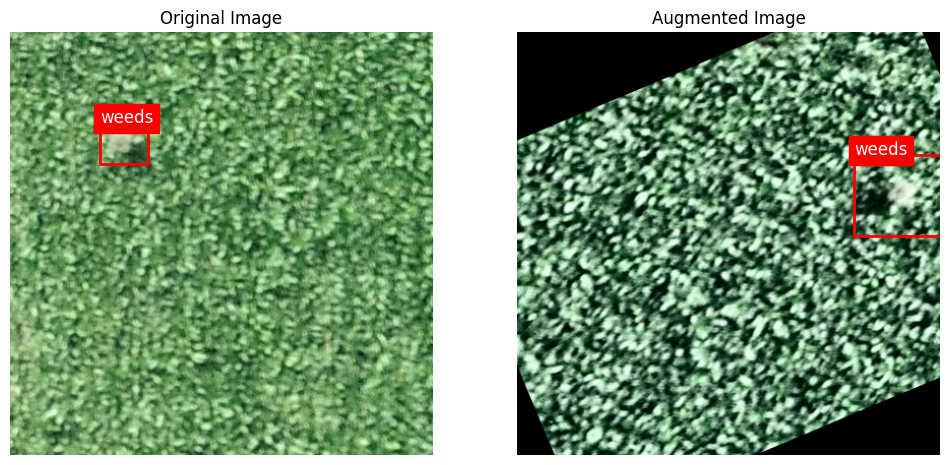

Augmented data saved to: /content/drive/MyDrive/datasets/Sample_Weed_dataset/train/augmented_images/augmented_annotations.csv
Transformation records saved to: /content/drive/MyDrive/datasets/Sample_Weed_dataset/train/augmented_images/transformations.csv

Transformation Records:
                                                   filename  \
0  DJI_0002_0_7_JPG.rf.fa43d6473d16ab2525cb952be8e7553f.jpg   
1  DJI_0002_1_3_JPG.rf.a9ec785ae0db2f7b5a9cc0aefdb8a1d2.jpg   
2  DJI_0002_4_2_JPG.rf.19554da414cc848cf7ef4d738afcc7b8.jpg   
3  DJI_0002_4_4_JPG.rf.8cfd62977517cb91ac1beb36f88d57f6.jpg   
4  DJI_0002_4_6_JPG.rf.d023fd8fd9c36217830754d7d3236255.jpg   

                                                                                                            applied_transforms  
0                            [LongestMaxSize, PadIfNeeded, RandomCrop, HorizontalFlip, RandomBrightnessContrast, GaussianBlur]  
1               [LongestMaxSize, PadIfNeeded, RandomCrop, HorizontalFlip, OneOf, Ran

In [41]:
import os
import cv2
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt

def plot_images_side_by_side(original_image, augmented_image, bboxes_original, bboxes_augmented, class_labels):
    plt.figure(figsize=(12, 6))

    # Plot Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    for bbox, label in zip(bboxes_original, class_labels):
        xmin, ymin, xmax, ymax = bbox
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(xmin, ymin, label, color='white', fontsize=12, backgroundcolor='red')
    plt.title('Original Image')
    plt.axis('off')

    # Plot Augmented Image
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image)
    for bbox, label in zip(bboxes_augmented, class_labels):
        xmin, ymin, xmax, ymax = bbox
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(xmin, ymin, label, color='white', fontsize=12, backgroundcolor='red')
    plt.title('Augmented Image')
    plt.axis('off')

    plt.show()

def augment_images_and_bboxes(folder_path, csv_filename):
    annotations_path = os.path.join(folder_path, csv_filename)
    df = pd.read_csv(annotations_path)

    augmented_folder = os.path.join(folder_path, 'augmented_images')
    if not os.path.exists(augmented_folder):
        os.makedirs(augmented_folder)

    # Augmentation pipeline
    transform = A.Compose([
        A.LongestMaxSize(max_size=416, p=1.0),
        A.PadIfNeeded(min_height=416, min_width=416, border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),
        A.RandomCrop(height=416, width=416, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.OneOf([
            A.RandomRotate90(p=0.5),
            A.Rotate(limit=45, p=0.5),
        ], p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.3),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_visibility=0.3, min_area=32))

    augmented_data = []
    transformation_records = []  # To store transformation details

    for idx, row in df.iterrows():
        image_path = os.path.join(folder_path, row['filename'])
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image not found: {image_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
        bboxes = [bbox]
        class_labels = [row['class']]

        try:
            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            aug_image = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_class_labels = augmented['class_labels']


            applied_transforms = [t.__class__.__name__ for t in transform.transforms if np.random.rand() < t.p]
            transformation_records.append({
                'filename': row['filename'],
                'applied_transforms': applied_transforms
            })


            plot_images_side_by_side(image, aug_image, bboxes, aug_bboxes, class_labels)

        except ValueError as e:
            print(f"Augmentation failed for {row['filename']}: {e}")
            continue

        new_filename = f"aug_{os.path.basename(row['filename'])}"
        new_image_path = os.path.join(augmented_folder, new_filename)
        cv2.imwrite(new_image_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

        for bbox, class_label in zip(aug_bboxes, aug_class_labels):
            augmented_data.append({
                'filename': new_filename,
                'width': 416,
                'height': 416,
                'class': class_label,
                'xmin': max(0, int(bbox[0])),
                'ymin': max(0, int(bbox[1])),
                'xmax': min(416, int(bbox[2])),
                'ymax': min(416, int(bbox[3]))
            })

    augmented_df = pd.DataFrame(augmented_data)
    new_annotations_path = os.path.join(augmented_folder, 'augmented_annotations.csv')
    augmented_df.to_csv(new_annotations_path, index=False)
    print(f"Augmented data saved to: {new_annotations_path}")

    transformation_df = pd.DataFrame(transformation_records)
    pd.set_option('display.max_colwidth', None)
    transformation_csv_path = os.path.join(augmented_folder, 'transformations.csv')
    transformation_df.to_csv(transformation_csv_path, index=False)
    print(f"Transformation records saved to: {transformation_csv_path}")

    print("\nTransformation Records:")
    print(transformation_df)

dataset_path = r"/content/drive/MyDrive/datasets/Sample_Weed_dataset"
train_folder = os.path.join(dataset_path, "train")
# test_folder = os.path.join(dataset_path, "test")

augment_images_and_bboxes(train_folder, '_annotations.csv')
# augment_images_and_bboxes(test_folder, '_annotations.csv')
